# Individual Household Electric Power Consumption Prediction

In [3]:
# Data Manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statistical Modeling and Visualization
import statsmodels.api as sm
from pylab import rcParams

# Forecasting Model
from prophet import Prophet

# Accuracy metric
from sklearn.metrics import mean_squared_error

## Data Loading and Preparation

In [4]:
df=pd.read_csv("Dataset/household_power_consumption.txt",delimiter=';')
df.head() 

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_9864\2924694369.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Dataset/household_power_consumption.txt",delimiter=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


Data Link: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption


The data includes measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

**Attribute Information**

<table>
<thead><tr>
<th><strong>Feature Name</strong></th>
<th><strong>Description</strong></th>
</tr>
</thead>
<tbody>
<tr>
<td>date</td>
<td>Date in format dd/mm/yyyy</td>
</tr>
<tr>
<td>time</td>
<td>time in format hh:mm:ss</td>
</tr>
<tr>
<td>globalactivepower</td>
<td>household global minute-averaged active power (in kilowatt)</td>
</tr>
<tr>
<td>globalreactivepower</td>
<td>household global minute-averaged reactive power (in kilowatt)</td>
</tr>
<tr>
<td>voltage</td>
<td>minute-averaged voltage (in volt)</td>
</tr>
<tr>
<td>global_intensity</td>
<td>household global minute-averaged current intensity (in ampere)</td>
</tr>
<tr>
<td>submetering1</td>
<td>energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered)</td>
</tr>
<tr>
<td>submetering2</td>
<td>energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light</td>
</tr>
<tr>
<td>submetering3</td>
<td>energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner</td>
</tr>
</tbody>
</table>

**Notes:**

1. (globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2. The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

In [6]:
# Combine Date and Time columns
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert columns to float
cols_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                   'Sub_metering_1', 'Sub_metering_2']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [7]:
df.set_index( "Datetime" , inplace= True )
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [9]:
missing = df.isna().sum()
missing_percentage = df.isna().sum() * 100 / len(df)

print(missing_percentage)
print(missing)

Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


Text(0, 0.5, 'Global active power')

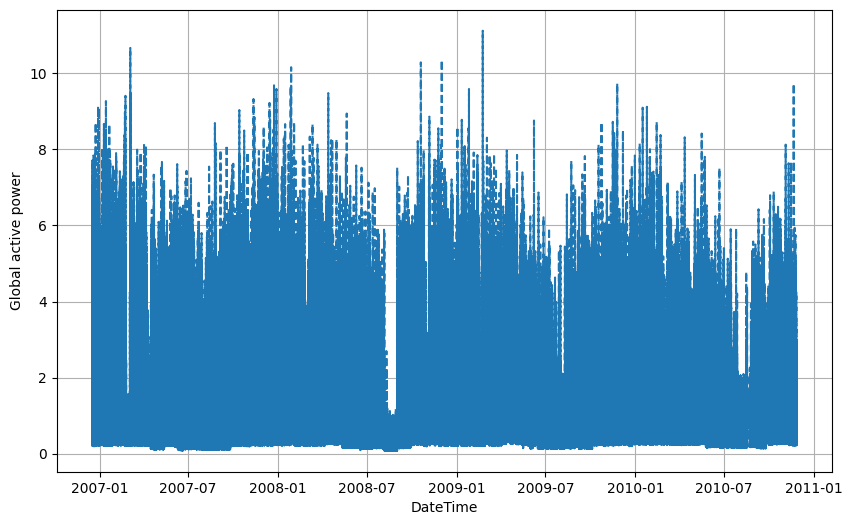

In [10]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Global_active_power, '--')
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Global active power')

In [11]:
# Forward fill null values

df_ffill = df.ffill()
df_ffill.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Downsampling

In [12]:
# Downsample to daily sum

df_global_ap = pd.DataFrame(df_ffill, columns=['Global_active_power'], index=df_ffill.index)
df_daily = df_global_ap.resample('D').sum()

Text(0, 0.5, 'Global active power')

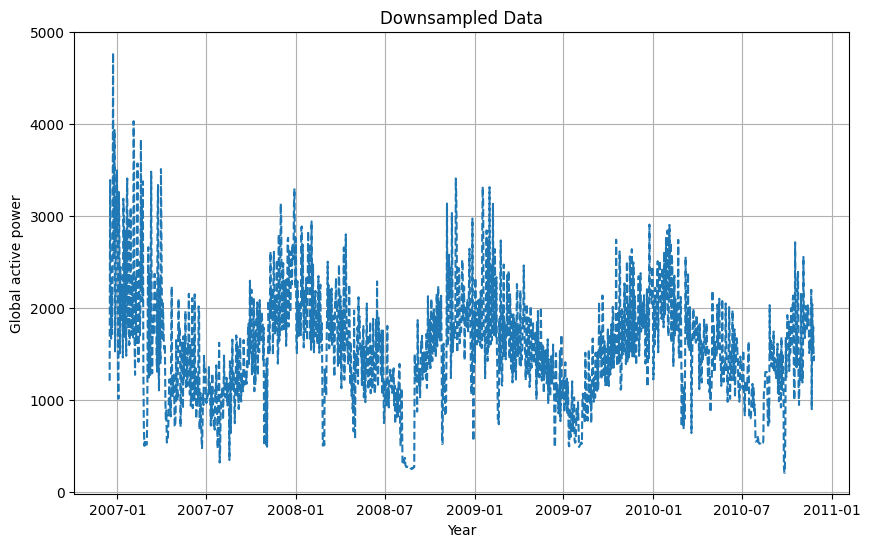

In [13]:
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.Global_active_power, '--')
plt.grid()
plt.title('Downsampled Data')
plt.xlabel('Year')
plt.ylabel('Global active power')

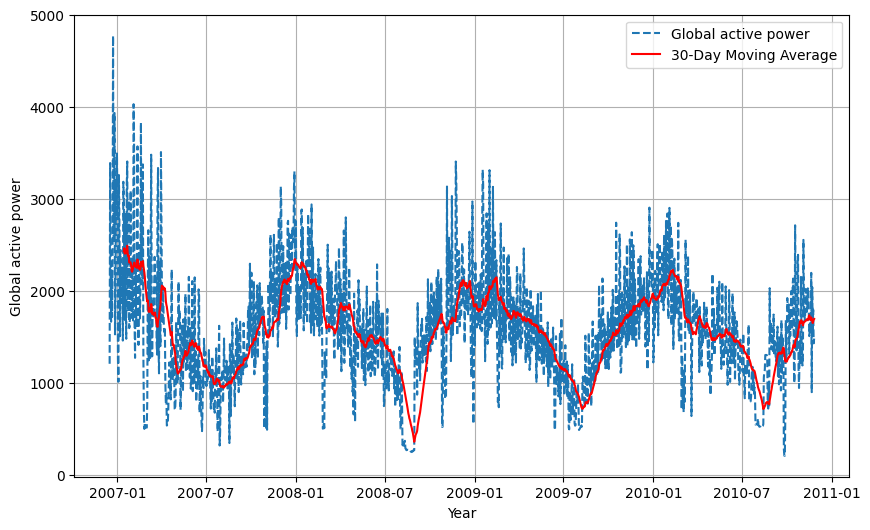

In [14]:
# Smoothing with Moving Average

df_MA = df_daily.copy()
MA = df_MA[ 'Global_active_power' ].rolling( 30 ).mean()

plt.figure(figsize=(10,6))
plt.plot(df_MA.index, df_MA.Global_active_power, '--' , label='Global active power')
plt.plot(df_MA.index, MA, label='30-Day Moving Average', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Global active power')
plt.legend()
plt.show()

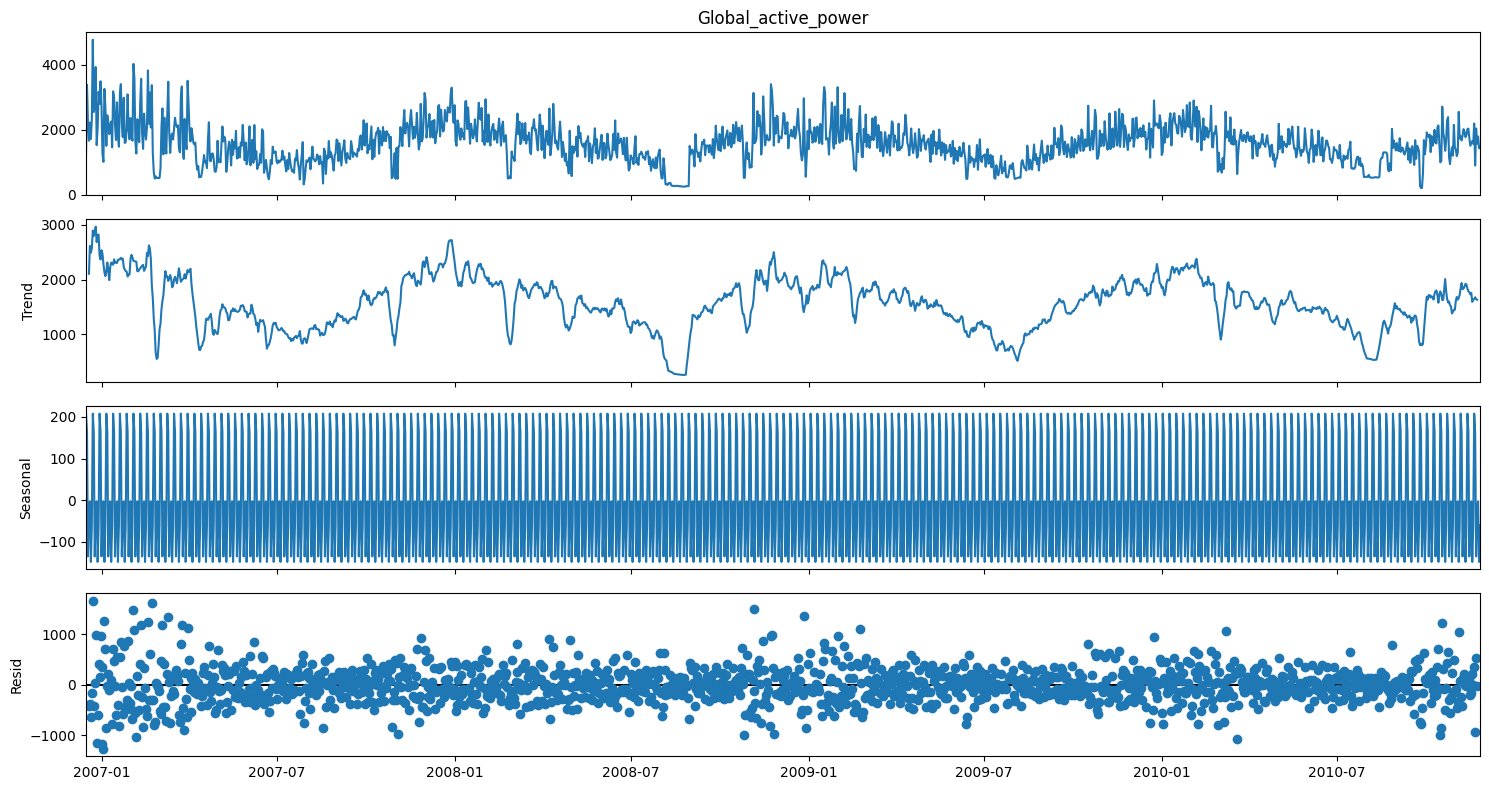

In [15]:
# Decompose trend and seasonal components

rcParams['figure.figsize'] = 15,8
decompose_series = sm.tsa.seasonal_decompose(df_daily['Global_active_power'], model='additive')
decompose_series.plot()
plt.show()

## Univariate Prophet Model

In [16]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Global_active_power  1442 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [17]:
df_daily.reset_index(inplace=True)
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             1442 non-null   datetime64[ns]
 1   Global_active_power  1442 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.7 KB


In [18]:
df_daily.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)
df_daily.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [19]:
length_dataset = len(df_daily)
test_days = 300
train_days = length_dataset - test_days

# Split the data into training and test sets
train_df = df_daily.iloc[:train_days]
test_df = df_daily.iloc[train_days:]

train_df.shape, test_df.shape

((1142, 2), (300, 2))

In [20]:
model = Prophet()

# Fit the model on the training data
model.fit(train_df)

# Make future predictions
future = model.make_future_dataframe(periods=test_days)

12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Forecast
forecast = model.predict(future)

In [22]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          1442 non-null   datetime64[ns]
 1   trend                       1442 non-null   float64       
 2   yhat_lower                  1442 non-null   float64       
 3   yhat_upper                  1442 non-null   float64       
 4   trend_lower                 1442 non-null   float64       
 5   trend_upper                 1442 non-null   float64       
 6   additive_terms              1442 non-null   float64       
 7   additive_terms_lower        1442 non-null   float64       
 8   additive_terms_upper        1442 non-null   float64       
 9   weekly                      1442 non-null   float64       
 10  weekly_lower                1442 non-null   float64       
 11  weekly_upper                1442 non-null   float64     

c:\Users\jmutonyi\Desktop\Data Science\Hamoye Data Science Internship\5. Practical Time Series Analysis & Forecasting\Elec_Prediction\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jmutonyi\Desktop\Data Science\Hamoye Data Science Internship\5. Practical Time Series Analysis & Forecasting\Elec_Prediction\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


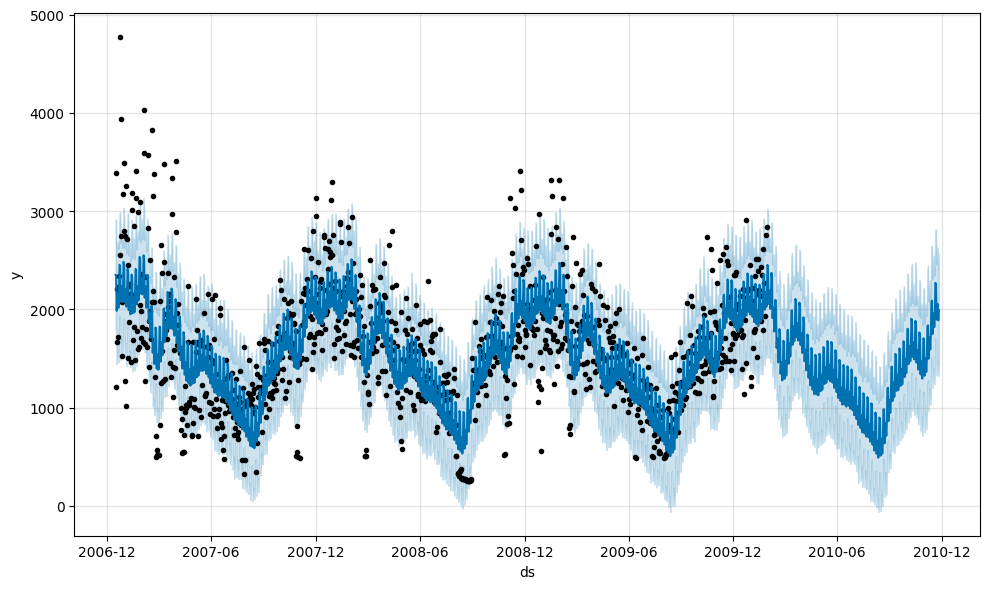

In [23]:
fig = model.plot(forecast)

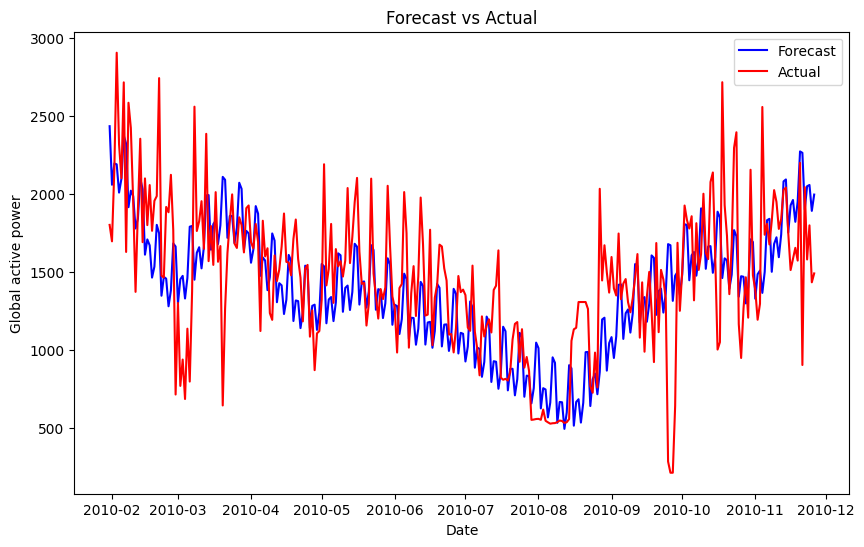

In [24]:
forecast_with_actual_1 = forecast[['ds', 'yhat']].merge(test_df, on='ds', how='inner')

# Plot the forecasted and actual values
plt.figure(figsize=(10, 6))
plt.plot(forecast_with_actual_1['ds'], forecast_with_actual_1['yhat'], label='Forecast', color='blue')
plt.plot(forecast_with_actual_1['ds'], forecast_with_actual_1['y'], label='Actual', color='red')
plt.xlabel('Date')
plt.ylabel('Global active power')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()


In [25]:
forecast_with_actual_1.head()

,ds,yhat,y
0,2010-01-31,2431.924199,1799.196
1,2010-02-01,2056.471462,1693.778
2,2010-02-02,2192.947558,2157.432
3,2010-02-03,2187.281456,2903.014
4,2010-02-04,2006.351533,2316.270


In [26]:
forecast_values_1 = forecast_with_actual_1['yhat']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(forecast_with_actual_1['y'], forecast_values_1))

print("RMSE:", rmse)

RMSE: 401.70426694952505


## Multivariate Prophet Model

In [27]:
# Downsample to daily sum

df_daily_multi = df_ffill.resample('D').sum()
df_daily_multi.reset_index(inplace=True)
df_daily_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Datetime               1442 non-null   datetime64[ns]
 1   Global_active_power    1442 non-null   float64       
 2   Global_reactive_power  1442 non-null   float64       
 3   Voltage                1442 non-null   float64       
 4   Global_intensity       1442 non-null   float64       
 5   Sub_metering_1         1442 non-null   float64       
 6   Sub_metering_2         1442 non-null   float64       
 7   Sub_metering_3         1442 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 90.3 KB


In [28]:
df_daily_multi.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y',
                               'Global_reactive_power': 'add1', 'Voltage': 'add2',
                               'Global_intensity':'add3', 'Sub_metering_1': 'add4',
                               'Sub_metering_2': 'add5', 'Sub_metering_3': 'add6'}, inplace=True)
df_daily_multi.columns

Index(['ds', 'y', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6'], dtype='object')

In [29]:
df_daily_multi.isna().sum()

ds      0
y       0
add1    0
add2    0
add3    0
add4    0
add5    0
add6    0
dtype: int64

In [30]:
df_daily_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1442 non-null   datetime64[ns]
 1   y       1442 non-null   float64       
 2   add1    1442 non-null   float64       
 3   add2    1442 non-null   float64       
 4   add3    1442 non-null   float64       
 5   add4    1442 non-null   float64       
 6   add5    1442 non-null   float64       
 7   add6    1442 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 90.3 KB


In [31]:
length_dataset_multi = len(df_daily_multi)
test_days_multi = 300
train_days_multi = length_dataset_multi - test_days_multi

# Split the data into training and test sets
train_multi_df = df_daily_multi.iloc[:train_days_multi]
test_multi_df = df_daily_multi.iloc[train_days_multi:]

train_multi_df.shape, test_multi_df.shape

((1142, 8), (300, 8))

In [32]:
m = Prophet()

# Add additional variables as regressors
m.add_regressor('add1')
m.add_regressor('add2')
m.add_regressor('add3')
m.add_regressor('add4')
m.add_regressor('add5')
m.add_regressor('add6')

# Fit the model on the training data
m.fit(train_multi_df)

12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:27 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# Make future predictions for the test set
future_multi = m.make_future_dataframe(periods=test_days_multi)

In [34]:
future_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1442 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 11.4 KB


In [35]:
# Concatenate regressors with future dataframe
future_multi = pd.concat([
    future_multi,
    df_daily_multi[['add1', 'add2', 'add3', 'add4', 'add5', 'add6']].reset_index(drop=True)
], axis=1)

In [36]:
future_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1442 non-null   datetime64[ns]
 1   add1    1442 non-null   float64       
 2   add2    1442 non-null   float64       
 3   add3    1442 non-null   float64       
 4   add4    1442 non-null   float64       
 5   add5    1442 non-null   float64       
 6   add6    1442 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 79.0 KB


In [37]:
forecast_2 = m.predict(future_multi)

c:\Users\jmutonyi\Desktop\Data Science\Hamoye Data Science Internship\5. Practical Time Series Analysis & Forecasting\Elec_Prediction\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jmutonyi\Desktop\Data Science\Hamoye Data Science Internship\5. Practical Time Series Analysis & Forecasting\Elec_Prediction\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


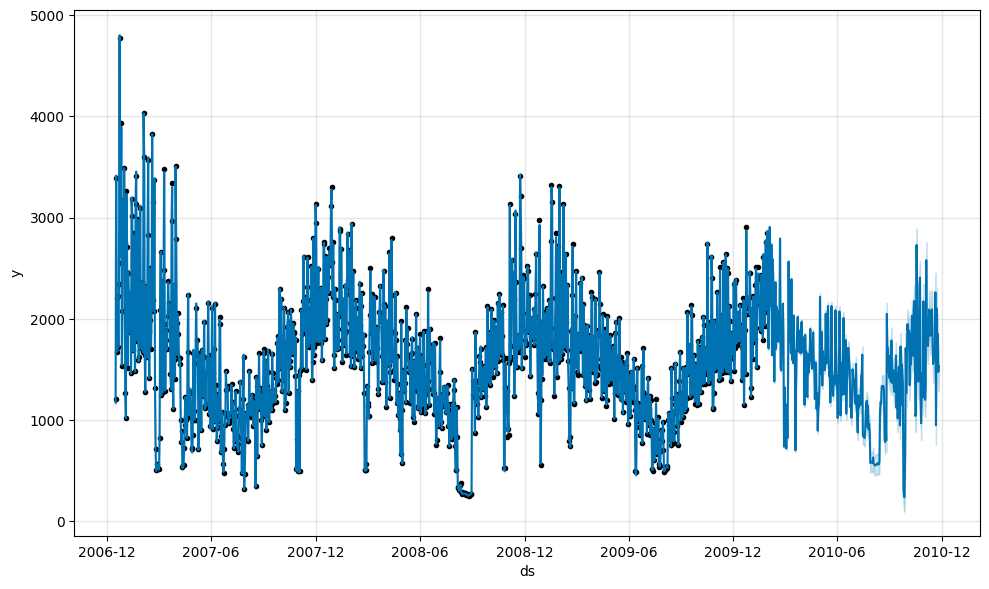

In [38]:
fig_2 = m.plot(forecast_2)

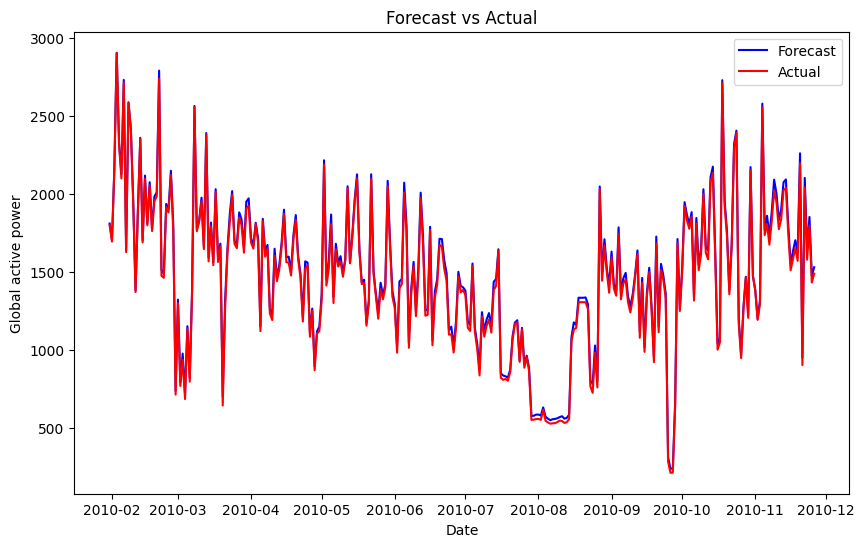

In [39]:
forecast_with_actual_2 = forecast_2[['ds', 'yhat']].merge(test_multi_df, on='ds', how='inner')

# Plot the forecasted and actual values
plt.figure(figsize=(10, 6))
plt.plot(forecast_with_actual_2['ds'], forecast_with_actual_2['yhat'], label='Forecast', color='blue')
plt.plot(forecast_with_actual_2['ds'], forecast_with_actual_2['y'], label='Actual', color='red')
plt.xlabel('Date')
plt.ylabel('Global active power')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

In [40]:
forecast_with_actual_2.head()

,ds,yhat,y,add1,add2,add3,add4,add5,add6
0,2010-01-31,1809.631975,1799.196,171.516,350499.80,7491.2,1715.0,1380.0,12569.0
1,2010-02-01,1704.960033,1693.778,124.784,350829.71,6995.2,1111.0,367.0,14623.0
2,2010-02-02,2158.319176,2157.432,131.168,350399.26,8853.6,0.0,382.0,21536.0
3,2010-02-03,2905.898951,2903.014,183.692,349038.83,12052.8,2234.0,8423.0,21130.0
4,2010-02-04,2330.777771,2316.270,141.848,348625.14,9567.2,1074.0,532.0,23743.0


In [41]:
forecast_values_2 = forecast_with_actual_2['yhat']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(forecast_with_actual_2['y'], forecast_values_2))

print("RMSE:", rmse)

RMSE: 32.52918882909641
